In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
import tensorflow as tf
import seaborn as sns
tf.test.gpu_device_name()

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
import ast
class allaction():
    
    def __init__(self, file):
        self.df = pd.read_csv(file) 
        # self.df = self.df.sample(frac=1, random_state=42).reset_index().drop("index", axis=1)
        self.orderId, self.taskId, self.taskTicks, self.workerId, self.workerTicks = [], [], [], [], []
        self.ResponseId, self.Round, self.Tick = [], [], []
    #taskId: 0~idle, 1~chop, 2~cook, 3~plate
    #workerId: 0~chef, 1~sou-chef, 2~server
    #           0~sou-chef, 1~server, CHANGE!!! 0~idle, 1~chef, 2~sou-chef, 3~server
    
    def parse(self):
        # all id + 1, leaving 0 to be idle
        action = self.df
        for i in tqdm(np.arange(action.shape[0])):
            row = action.iloc[i,:]
            for act in ["action1", "action2", "action3"]:
                # when there is no action in this act
                if type(row[act]) != str:
                    self.orderId.append(0)
                    self.taskId.append(0)
                    self.taskTicks.append(0)
                    self.workerId.append(0)
                    self.workerTicks.append(0)
                else:
                    a = ast.literal_eval(row[act])
                    self.orderId.append(a["order_id"] + 1)
                    self.taskId.append(a["task_id"] + 1)
                    self.taskTicks.append(a["task_ticks"])
                    self.workerId.append(a["worker_id"] + 1)
                    self.workerTicks.append(a["worker_ticks"])

                self.ResponseId.append(row["ResponseId"])
                self.Round.append(row["round"])
                self.Tick.append(row["tick"])
                
    def get(self):
        self.parse()
        d = {
            "ResponseId": self.ResponseId,
            "round": self.Round,
            "tick": self.Tick,
            "orderId": self.orderId, 
            "taskId": self.taskId, 
            "taskTicks": self.taskTicks, 
            "workerId": self.workerId, 
            "workerTicks": self.workerTicks
        }
        return pd.DataFrame(d)

In [172]:
% pwd

'/content'

In [5]:
file =  "./data/phase2/phase2_action.csv"
action = allaction(file).get()
action = action[action["round"] <= 2]
action = action.drop("workerTicks", axis=1)
action

100%|██████████| 195642/195642 [00:35<00:00, 5504.57it/s]


,ResponseId,round,tick,orderId,taskId,taskTicks,workerId
0,R_09f8RCjNyCadwPv,1,1,1,1,2,1
1,R_09f8RCjNyCadwPv,1,1,2,1,2,2
2,R_09f8RCjNyCadwPv,1,1,3,1,2,3
3,R_09f8RCjNyCadwPv,1,2,0,0,0,0
4,R_09f8RCjNyCadwPv,1,2,0,0,0,0
...,...,...,...,...,...,...,...
586474,R_zffMypmlgQF5Yl3,2,18,0,0,0,0
586475,R_zffMypmlgQF5Yl3,2,18,0,0,0,0
586476,R_zffMypmlgQF5Yl3,2,19,4,3,2,3
586477,R_zffMypmlgQF5Yl3,2,19,0,0,0,0


In [174]:
label=pd.read_csv( "label_after.csv").drop("Unnamed: 0", axis=1)
label

,ResponseId,label,suggested_tip_disrupted
0,R_10HkPUkR6o0qDFT,9,Server cooks twice
1,R_1JCkfcOwq1eNbLu,9,"Make sure the server cooks twice, even if that..."
2,R_1K3WThoBHDDfbk0,9,the server needs to cook twice
3,R_1M40hSm4fF4Saxv,9,Server cooks twice
4,R_1Q5tRaFyI9DwIn4,9,Make the server cook twice
...,...,...,...
285,R_XoEfxfWvLu2dznr,8,good
286,R_2s5D6EJ0FlMyr39,8,0.5
287,R_2Vf01KGZrR5fscp,1,leave some chefs idle
288,R_38EvwAyoLTJRsZP,8,game didn't load


In [175]:
action = action.merge(label,how = "inner",
            left_on="ResponseId", right_on="ResponseId")
y = action["label"]
action = action.iloc[:,0:7]
action

,ResponseId,round,tick,orderId,taskId,taskTicks,workerId
0,R_0HBxBV8U696D9QJ,1,1,1,1,2,1
1,R_0HBxBV8U696D9QJ,1,1,2,1,2,2
2,R_0HBxBV8U696D9QJ,1,1,3,1,2,3
3,R_0HBxBV8U696D9QJ,1,2,0,0,0,0
4,R_0HBxBV8U696D9QJ,1,2,0,0,0,0
...,...,...,...,...,...,...,...
33427,R_zZQIbE0LFD13yRX,2,29,0,0,0,0
33428,R_zZQIbE0LFD13yRX,2,29,0,0,0,0
33429,R_zZQIbE0LFD13yRX,2,30,0,0,0,0
33430,R_zZQIbE0LFD13yRX,2,30,0,0,0,0


In [176]:
y = action.merge(label,how = "inner",
            left_on="ResponseId", right_on="ResponseId").groupby("ResponseId").agg(np.mean)["label"].astype(int)
y = y-1
y

ResponseId
R_0HBxBV8U696D9QJ    1
R_0SZ9OfuWvmqeMqR    5
R_10DdLv5uPLAfpAR    2
R_10Ggl6dEPfo9ipw    0
R_10HkPUkR6o0qDFT    8
                    ..
R_yZJ03FFfe8jfazn    8
R_ykkhkGYu1KpIM8h    0
R_ym9gyf6T2XORxAt    0
R_z8OxWJ4ua6nKKB3    7
R_zZQIbE0LFD13yRX    2
Name: label, Length: 245, dtype: int64

In [177]:
t1 = action.drop("orderId", axis=1)
t2 = t1.merge(pd.get_dummies(t1["taskId"]), left_index=True, right_index=True).drop("taskId", axis=1).rename(
    columns={0:"idle", 1:"chop", 2:"cook", 3:"plate"})
df = t2.merge(pd.get_dummies(t2["workerId"]), left_index=True, right_index=True).drop("workerId", axis=1).rename(
    columns={0:"idle", 1:"chef", 2:"sou-chef", 3:"server"})
df.drop("taskTicks", axis=1).groupby(["ResponseId", "round", "tick"]).sum().iloc[:,1:]

chop  cook  plate  idle  chef  sou-chef  server
ResponseId        round tick                                                 
R_0HBxBV8U696D9QJ 1     1        3     0      0     0     1         1       1
                        2        0     0      0     3     0         0       0
                        3        0     1      0     2     1         0       0
                        4        0     1      0     2     1         0       0
                        5        0     2      0     1     1         1       0
...                            ...   ...    ...   ...   ...       ...     ...
R_zZQIbE0LFD13yRX 2     26       0     0      0     3     0         0       0
                        27       0     0      0     3     0         0       0
                        28       0     0      0     3     0         0       0
                        29       0     0      0     3     0         0       0
                        30       0     0      0     3     0         0       0

[11144 rows x 7 columns]

In [178]:
df = df.merge(pd.DataFrame(y), how="left",left_on="ResponseId", right_index=True)
df

,ResponseId,round,tick,taskTicks,idle,chop,cook,plate,idle,chef,sou-chef,server,label
0,R_0HBxBV8U696D9QJ,1,1,2,0,1,0,0,0,1,0,0,1
1,R_0HBxBV8U696D9QJ,1,1,2,0,1,0,0,0,0,1,0,1
2,R_0HBxBV8U696D9QJ,1,1,2,0,1,0,0,0,0,0,1,1
3,R_0HBxBV8U696D9QJ,1,2,0,1,0,0,0,1,0,0,0,1
4,R_0HBxBV8U696D9QJ,1,2,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33427,R_zZQIbE0LFD13yRX,2,29,0,1,0,0,0,1,0,0,0,2
33428,R_zZQIbE0LFD13yRX,2,29,0,1,0,0,0,1,0,0,0,2
33429,R_zZQIbE0LFD13yRX,2,30,0,1,0,0,0,1,0,0,0,2
33430,R_zZQIbE0LFD13yRX,2,30,0,1,0,0,0,1,0,0,0,2


In [179]:
a = df.drop("taskTicks", axis=1)
X = a.groupby(["ResponseId", "round", "tick", "label"]).agg(lambda x: x.iloc[0]).merge(
    a.groupby(["ResponseId", "round", "tick", "label"]).agg(lambda x: x.iloc[1]).merge(
        a.groupby(["ResponseId", "round", "tick", "label"]).agg(lambda x: x.iloc[2])
    , left_index=True, right_index=True), left_index=True, right_index=True)

In [180]:
X

idle  chop  cook  plate  idle  chef  \
ResponseId        round tick label                                        
R_0HBxBV8U696D9QJ 1     1    1         0     1     0      0     0     1   
                        2    1         1     0     0      0     1     0   
                        3    1         0     0     1      0     0     1   
                        4    1         0     0     1      0     0     1   
                        5    1         0     0     1      0     0     1   
...                                  ...   ...   ...    ...   ...   ...   
R_zZQIbE0LFD13yRX 2     26   2         1     0     0      0     1     0   
                        27   2         1     0     0      0     1     0   
                        28   2         1     0     0      0     1     0   
                        29   2         1     0     0      0     1     0   
                        30   2         1     0     0      0     1     0   

                                    sou-chef  server  idle_x  chop_x  ...  \
ResponseId        round tick label                                    ...   
R_0HBxBV8U696D9QJ 1     1    1             0       0       0       1  ...   
                        2    1             0       0       1       0  ...   
                        3    1             0       0       1       0  ...   
                        4    1             0       0       1       0  ...   
                        5    1             0       0       0       0  ...   
...                                      ...     ...     ...     ...  ...   
R_zZQIbE0LFD13yRX 2     26   2             0       0       1       0  ...   
                        27   2             0       0       1       0  ...   
                        28   2             0       0       1       0  ...   
                        29   2             0       0       1       0  ...   
                        30   2             0       0       1       0  ...   

                                    sou-chef_x  server_x  idle_y  chop_y  \
ResponseId        round tick label                                         
R_0HBxBV8U696D9QJ 1     1    1               1         0       0       1   
                        2    1               0         0       1       0   
                        3    1               0         0       1       0   
                        4    1               0         0       1       0   
                        5    1               1         0       1       0   
...                                        ...       ...     ...     ...   
R_zZQIbE0LFD13yRX 2     26   2               0         0       1       0   
                        27   2               0         0       1       0   
                        28   2               0         0       1       0   
                        29   2               0         0       1       0   
                        30   2               0         0       1       0   

                                    cook_y  plate_y  idle_y  chef_y  \
ResponseId        round tick label                                    
R_0HBxBV8U696D9QJ 1     1    1           0        0       0       0   
                        2    1           0        0       1       0   
                        3    1           0        0       1       0   
                        4    1           0        0       1       0   
                        5    1           0        0       1       0   
...                                    ...      ...     ...     ...   
R_zZQIbE0LFD13yRX 2     26   2           0        0       1       0   
                        27   2           0        0       1       0   
                        28   2           0        0       1       0   
                        29   2           0        0       1       0   
                        30   2           0        0       1       0   

                                    sou-chef_y  server_y  
ResponseId        round tick label                        
R_0HBxBV8U696D9QJ 1     1  

In [181]:
from tqdm import tqdm

In [182]:
# chop0, chef0, server3
embeddings = []
for i in tqdm(np.arange(X.shape[0])):
    embedding = [0,0,0,0,0,0,0,0,0]
    thisline = X.iloc[i,:]
    
    if thisline["chop"] and thisline["chef"]:
        embedding[0] = 1
    elif thisline["chop"] and thisline["sou-chef"]:
        embedding[1] = 1
    elif thisline["chop"] and thisline["server"]:
        embedding[2] = 1 
    elif thisline["cook"] and thisline["chef"]:
        embedding[3] = 1 
    elif thisline["cook"] and thisline["sou-chef"]:
        embedding[4] = 1
    elif thisline["cook"] and thisline["server"]:
        embedding[5] = 1 
    elif thisline["plate"] and thisline["chef"]:
        embedding[6] = 1 
    elif thisline["plate"] and thisline["sou-chef"]:
        embedding[7] = 1
    elif thisline["plate"] and thisline["server"]:
        embedding[8] = 1 
        
    if thisline["chop_x"] and thisline["chef_x"]:
        embedding[0] = 1
    elif thisline["chop_x"] and thisline["sou-chef_x"]:
        embedding[1] = 1
    elif thisline["chop_x"] and thisline["server_x"]:
        embedding[2] = 1 
    elif thisline["cook_x"] and thisline["chef_x"]:
        embedding[3] = 1 
    elif thisline["cook_x"] and thisline["sou-chef_x"]:
        embedding[4] = 1
    elif thisline["cook_x"] and thisline["server_x"]:
        embedding[5] = 1 
    elif thisline["plate_x"] and thisline["chef_x"]:
        embedding[6] = 1 
    elif thisline["plate_x"] and thisline["sou-chef_x"]:
        embedding[7] = 1
    elif thisline["plate_x"] and thisline["server_x"]:
        embedding[8] = 1         
        
    if thisline["chop_y"] and thisline["chef_y"]:
        embedding[0] = 1
    elif thisline["chop_y"] and thisline["sou-chef_y"]:
        embedding[1] = 1
    elif thisline["chop_y"] and thisline["server_y"]:
        embedding[2] = 1 
    elif thisline["cook_y"] and thisline["chef_y"]:
        embedding[3] = 1 
    elif thisline["cook_y"] and thisline["sou-chef_y"]:
        embedding[4] = 1
    elif thisline["cook_y"] and thisline["server_y"]:
        embedding[5] = 1 
    elif thisline["plate_y"] and thisline["chef_y"]:
        embedding[6] = 1 
    elif thisline["plate_y"] and thisline["sou-chef_y"]:
        embedding[7] = 1
    elif thisline["plate_y"] and thisline["server_y"]:
        embedding[8] = 1  
    
    embeddings.append(embedding)
   

100%|██████████| 11144/11144 [00:25<00:00, 429.55it/s] 


In [199]:
kkk = df.drop("taskTicks", axis=1).groupby(["ResponseId", "round", "tick", "label"]).sum().iloc[:,1:]
kkk["index"] = np.arange(kkk.shape[0])
X = kkk.merge(pd.DataFrame(np.array(embeddings)),how="left", left_on="index", right_index=True).drop(
    "chop", axis=1).drop("cook", axis=1).drop("plate", axis=1).drop("idle", axis=1).drop(
    "chef", axis=1).drop("sou-chef", axis=1).drop("server", axis=1).drop("index", axis=1)
X = X.reset_index()
X

,ResponseId,round,tick,label,0,1,2,3,4,5,6,7,8
0,R_0HBxBV8U696D9QJ,1,1,1,1,1,1,0,0,0,0,0,0
1,R_0HBxBV8U696D9QJ,1,2,1,0,0,0,0,0,0,0,0,0
2,R_0HBxBV8U696D9QJ,1,3,1,0,0,0,1,0,0,0,0,0
3,R_0HBxBV8U696D9QJ,1,4,1,0,0,0,1,0,0,0,0,0
4,R_0HBxBV8U696D9QJ,1,5,1,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11139,R_zZQIbE0LFD13yRX,2,26,2,0,0,0,0,0,0,0,0,0
11140,R_zZQIbE0LFD13yRX,2,27,2,0,0,0,0,0,0,0,0,0
11141,R_zZQIbE0LFD13yRX,2,28,2,0,0,0,0,0,0,0,0,0
11142,R_zZQIbE0LFD13yRX,2,29,2,0,0,0,0,0,0,0,0,0


In [184]:
# id = X.groupby(["ResponseId","tick").agg(lambda x: x.iloc[0])
# id = id.sample(frac=1, random_state=42)
# TRAIN = id.iloc[:200,:]
# TEST = id.iloc[200:,:]
# TRAIN

In [185]:
# sns.histplot(data=TRAIN, x="label")

In [186]:
# sns.histplot(data=TEST, x="label")

In [187]:
import imblearn
from imblearn.over_sampling import RandomOverSampler

In [188]:
# TRAIN["id"] = TRAIN.index
# TRAIN

In [189]:
# oversample = RandomOverSampler(sampling_strategy="not minority")
# jisoo, mmy = oversample.fit_resample(TRAIN.drop("label", axis=1), TRAIN["label"])
# oversample2 = RandomOverSampler(sampling_strategy="minority")
# jisoo, mmy = oversample2.fit_resample(jisoo, mmy)
# sampled = jisoo.merge(mmy, left_index=True, right_index=True)
# sampled = sampled.merge(TRAIN, how="left", left_on="id", right_on="id")
# sampled = sampled.drop(['round_y', 'tick_y', 'label_y', '0_y',
#        '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y', '8_y'], axis=1)
# sampled = sampled.rename(columns={
#     "round_x":"round",
#     "tick_x":"tick",
#     "0_x":"0",
#     "1_x":"1",
#     "2_x":"2",
#     "3_x":"3",
#     "4_x":"4",
#     "5_x":"5",
#     "6_x":"6",
#     "7_x":"7",
#     "8_x":"8",
#     "label_x":"label",
#     "id":"ResponseId"
# })
# sampled = sampled.set_index("ResponseId")
# TRAIN = sampled.iloc[:,[0,1,11,2,3,4,5,6,7,8,9,10]]
# TRAIN

In [190]:
# TEST

In [191]:
# after = pd.DataFrame(mmy).reset_index()
# sns.histplot(data=after, x="label")

In [192]:
max_time_tick = max(X.groupby("ResponseId").count()["round"])

In [200]:
X 

,ResponseId,round,tick,label,0,1,2,3,4,5,6,7,8
0,R_0HBxBV8U696D9QJ,1,1,1,1,1,1,0,0,0,0,0,0
1,R_0HBxBV8U696D9QJ,1,2,1,0,0,0,0,0,0,0,0,0
2,R_0HBxBV8U696D9QJ,1,3,1,0,0,0,1,0,0,0,0,0
3,R_0HBxBV8U696D9QJ,1,4,1,0,0,0,1,0,0,0,0,0
4,R_0HBxBV8U696D9QJ,1,5,1,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11139,R_zZQIbE0LFD13yRX,2,26,2,0,0,0,0,0,0,0,0,0
11140,R_zZQIbE0LFD13yRX,2,27,2,0,0,0,0,0,0,0,0,0
11141,R_zZQIbE0LFD13yRX,2,28,2,0,0,0,0,0,0,0,0,0
11142,R_zZQIbE0LFD13yRX,2,29,2,0,0,0,0,0,0,0,0,0


In [165]:
# TRAIN["newId"] = np.arange(531)
# TRAIN["round"].unique()

In [203]:
data = []
for player in tqdm(set(X["ResponseId"])):
    batch = np.array(X[X["ResponseId"] == player].iloc[:,4:]).tolist()
    padding = max_time_tick - len(batch)
    if padding > 0  :
        for _ in np.arange(padding):
            batch.append([0,0,0,0,0,0,0,0,0])
    data.append(batch)

100%|██████████| 245/245 [00:00<00:00, 370.05it/s]


In [ ]:
tensor = np.array(data)
tensor

In [205]:
from tensorflow import keras
from tensorflow.keras import layers

In [206]:
y.unique()

array([1, 5, 2, 0, 8, 7, 4, 3, 6])

In [213]:
X_train, y_train = tensor[:200], y[:200]
X_test, y_test = tensor[200:], y[200:]
X_train.shape

(200, 83, 9)

In [246]:
x_id = np.arange(200)

In [258]:
oversample = RandomOverSampler(sampling_strategy="not minority")
jisoo, mmy = oversample.fit_resample(x_id.reshape(-1, 1), y_train)
oversample2 = RandomOverSampler(sampling_strategy="minority")
id, y_train_new = oversample2.fit_resample(jisoo, mmy)
new = []
for i in tqdm(id.squeeze()):
  new.append(X_train[i].tolist())
X_train_new =  np.array(new)
y_train_new.shape

100%|██████████| 567/567 [00:00<00:00, 19580.19it/s]


(567,)

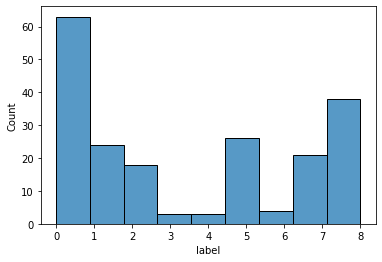

In [259]:
sns.histplot(y_train)

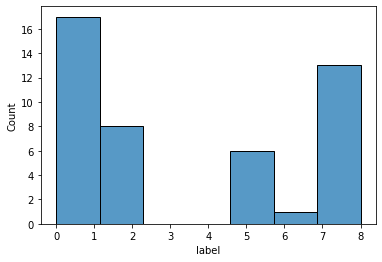

In [260]:
sns.histplot(y_test)

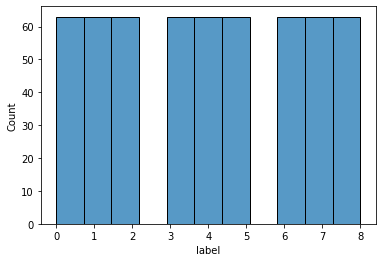

In [261]:
sns.histplot(y_train_new)

In [270]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=10, kernel_size=20, padding="same", activation="relu", kernel_regularizer = "l1")(x)
    x = layers.Conv1D(filters=8, kernel_size=15, padding="same",activation="relu", kernel_regularizer = "l1")(x)
    x = layers.Conv1D(filters=8, kernel_size=10, padding="same",activation="relu", kernel_regularizer = "l1")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=8, kernel_size=5, padding="same",activation="relu", kernel_regularizer = "l1")(x)
    x = layers.Conv1D(filters=5, kernel_size=5, padding="same",activation="relu", kernel_regularizer = "l1")(x)
    x = layers.Conv1D(filters=5, kernel_size=5, padding="same",activation="relu", kernel_regularizer = "l1")(x)
    x = layers.Conv1D(filters=5, kernel_size=3, padding="same",activation="relu", kernel_regularizer = "l1")(x)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu", kernel_regularizer = "l1")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [271]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    n_classes = 9
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    # for dim in mlp_units:
    x = layers.Dense(256, activation="relu", kernel_regularizer = "l1")(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer = "l1")(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer = "l1")(x)
    x = layers.Dense(32, activation="relu", kernel_regularizer = "l1")(x)
    x = layers.Dense(16, activation="relu", kernel_regularizer = "l1")(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [274]:
input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=128,
    num_heads=16,
    ff_dim=3,
    num_transformer_blocks=16,
    mlp_units=[128],
    mlp_dropout=0.35,
    dropout=0.25,
    # n_classes = 10
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"],
)
history = model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=1000, restore_best_weights=True)]

curve = model.fit(
    X_train_new,
    y_train_new,
    validation_split=0.3,
    epochs=1500,
    batch_size=16,
    #callbacks=callbacks,
)

model.evaluate(X_test, y_test, verbose=1)

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 83, 9)]      0           []                               
                                                                                                  
 layer_normalization_480 (Layer  (None, 83, 9)       18          ['input_16[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_240 (Mult  (None, 83, 9)       79881       ['layer_normalization_480[0][0]',
 iHeadAttention)                                                  'layer_normalization_480[0][0]']
                                                                                           

KeyboardInterrupt: ignored

In [ ]:
def extract(arr):
  out = []
  for weights in arr:
    max_weights = np.argmax(weights)
    out.append(max_weights)
  return out

In [ ]:
sum(extract(model.predict(X_test)) == y_test) / len(y_test)

In [ ]:
y_pred = np.array(extract(model.predict(X_test))) 
y_pred

In [ ]:
y_train

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
y_pred = y_pred
matrix = confusion_matrix(y_test, y_pred)
im = plt.imshow(matrix)
plt.colorbar(im)
plt.show()

In [ ]:
plt.plot(curve.history['accuracy'])
plt.plot(curve.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(curve.history['loss'])
plt.plot(curve.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()